In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az


sns.set_style("whitegrid")

In [2]:
train_reg = pd.read_csv('train_reg.csv')
# columns = ['a', 'b', 'c']
X_train = train_reg['x'].values
y_train = train_reg['y'].values

## Первая модель

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.675,0.320,-1.285,-0.084,0.005,0.004,3529.0,3513.0,1.0
β,3.080,0.049,2.987,3.172,0.001,0.001,3537.0,3614.0,1.0
ε,1.694,0.122,1.479,1.935,0.002,0.001,5081.0,4703.0,1.0


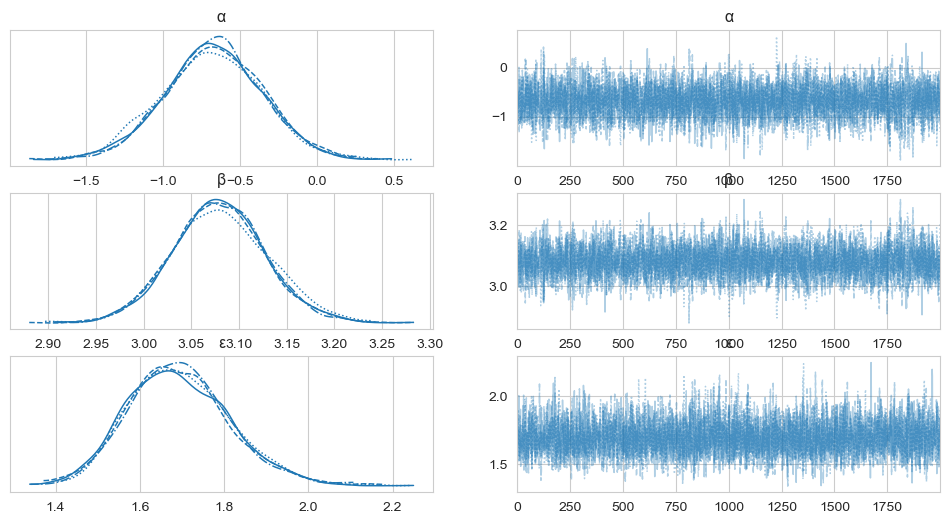

In [3]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

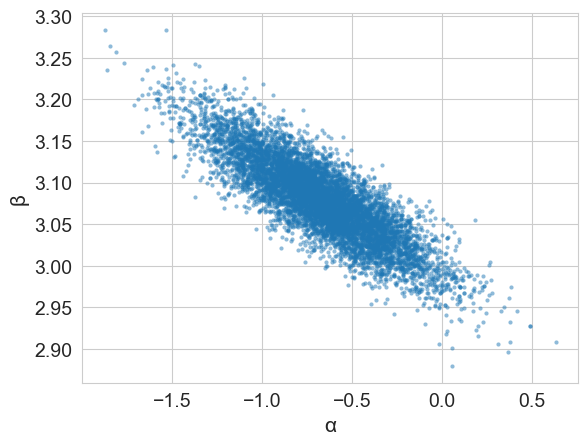

In [4]:
az.plot_pair(trace_g, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.5});

## Вторая модель

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [α]
>Metropolis: [β]
>Metropolis: [ε]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.662,0.302,-1.265,-0.121,0.020,0.014,238.0,486.0,1.01
β,3.077,0.046,2.992,3.162,0.003,0.002,226.0,468.0,1.01
ε,1.695,0.127,1.457,1.922,0.004,0.003,1237.0,1206.0,1.00


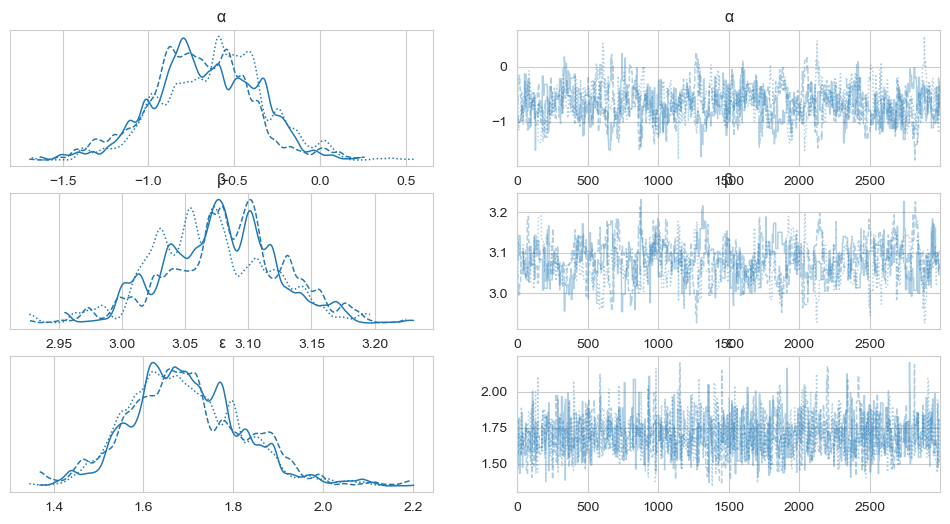

In [5]:
with pm.Model() as model_m:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_m = pm.sample(3000, tune=1000, step = pm.Metropolis() )

az.plot_trace(trace_m, var_names=['α', 'β', 'ε']);
az.summary(trace_m).head(3)

## Отстандартизированная модель

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [α]
>Metropolis: [β]
>Metropolis: [ε]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.000,0.015,-0.028,0.028,0.0,0.0,1840.0,1770.0,1.0
β,0.989,0.015,0.962,1.020,0.0,0.0,1853.0,1978.0,1.0
ε,0.154,0.011,0.135,0.177,0.0,0.0,2050.0,1907.0,1.0


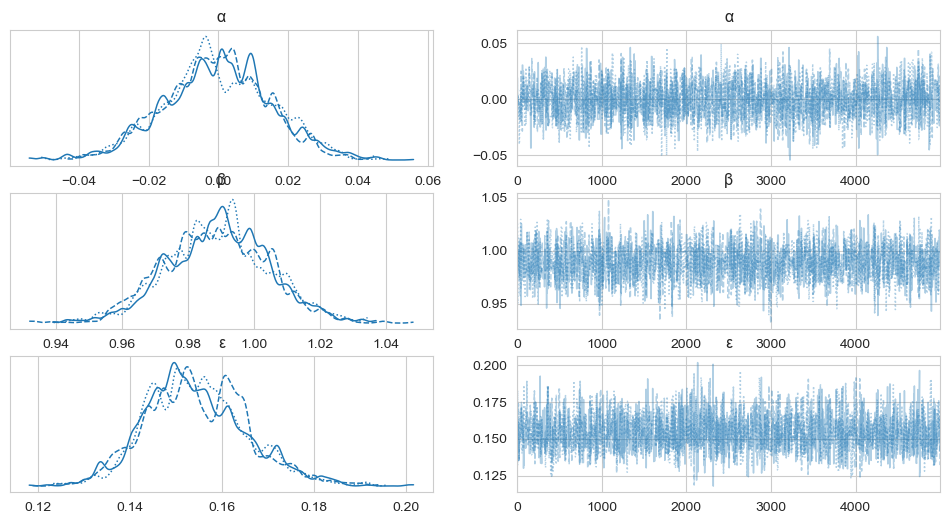

In [6]:
xm = X_train.mean()
xs = X_train.std()
ym = y_train.mean()
ys = y_train.std()

with pm.Model() as model_m:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * (X_train-xm)/xs  )
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=(y_train-ym)/ys)
    trace_m = pm.sample(5000, step = pm.Metropolis() )

az.plot_trace(trace_m, var_names=['α', 'β', 'ε']);
az.summary(trace_m).head(3)

Не лучшим образом описывает наши параметры

всего трасс :  8000


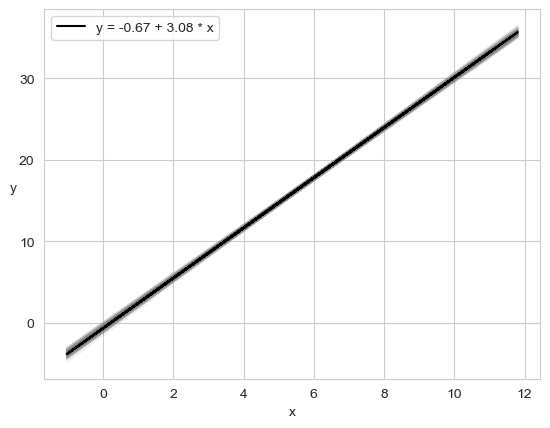

In [7]:
posterior_g = az.extract(trace_g)


alpha_m = posterior_g['α'].mean().item()
beta_m  = posterior_g['β'].mean().item()

print("всего трасс : ", posterior_g.sample.size)

draws = range(0, posterior_g.sample.size, 100)

plt.plot(X_train, posterior_g['α'][draws].values +
                 posterior_g['β'][draws].values * X_train[:,None], c='gray', alpha=0.1)

plt.plot(X_train, alpha_m + beta_m * X_train, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

## плотность апостериорного распределения первой модели

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


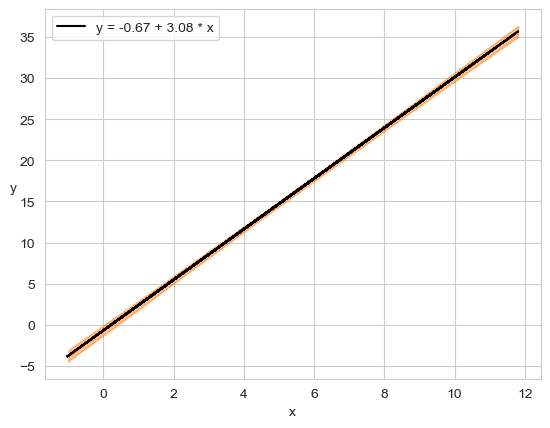

In [8]:
plt.plot(X_train, alpha_m + beta_m * X_train, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(X_train, posterior_g['μ'].T, hdi_prob=0.94)

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend();

In [9]:
ppc = pm.sample_posterior_predictive(trace_g, model=model_g)

Sampling: [y_pred]


In [10]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

Как условно ложится предикт линия на тренировочные данные, чтобы посмотреть на общий масштаб

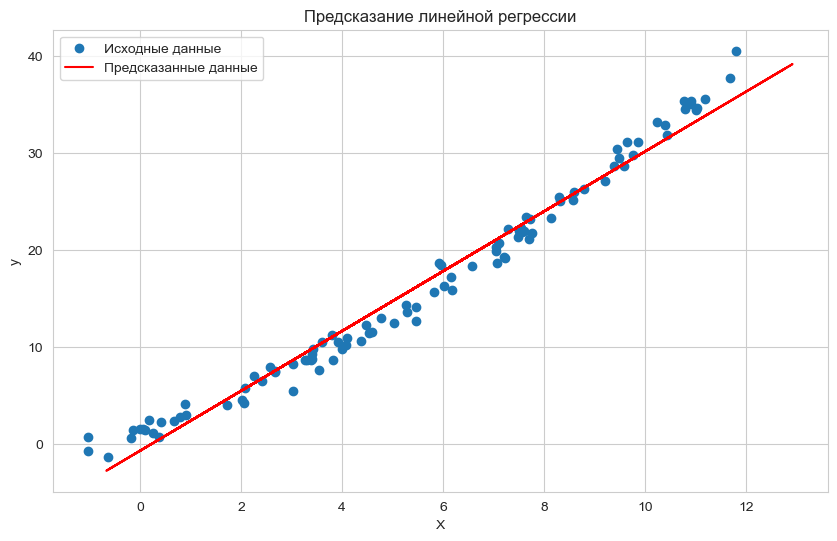

In [11]:

alpha = trace_g.posterior['α'].mean(("chain", "draw")).values
betta = trace_g.posterior["β"].mean(("chain", "draw")).values
# alpha_mean = -0.675
# beta_mean = 3.08

# Тестовые данные
X_test = pd.read_csv('test_reg.csv')  # Пример тестовых данных

# Предсказания для тестовых данных
y_pred_test = alpha + betta * X_test

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Исходные данные')
plt.plot(X_test, y_pred_test, color='red', label='Предсказанные данные')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Предсказание линейной регрессии')
plt.show()

In [12]:
y_pred_test

,x
0,17.536690
1,7.510465
2,-2.726619
3,29.785719
4,21.572383
...,...
95,27.637157
96,31.924406
97,5.005927
98,0.981596


y_pred_test

## 4 модель

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_tmp, β, ε, ν_]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


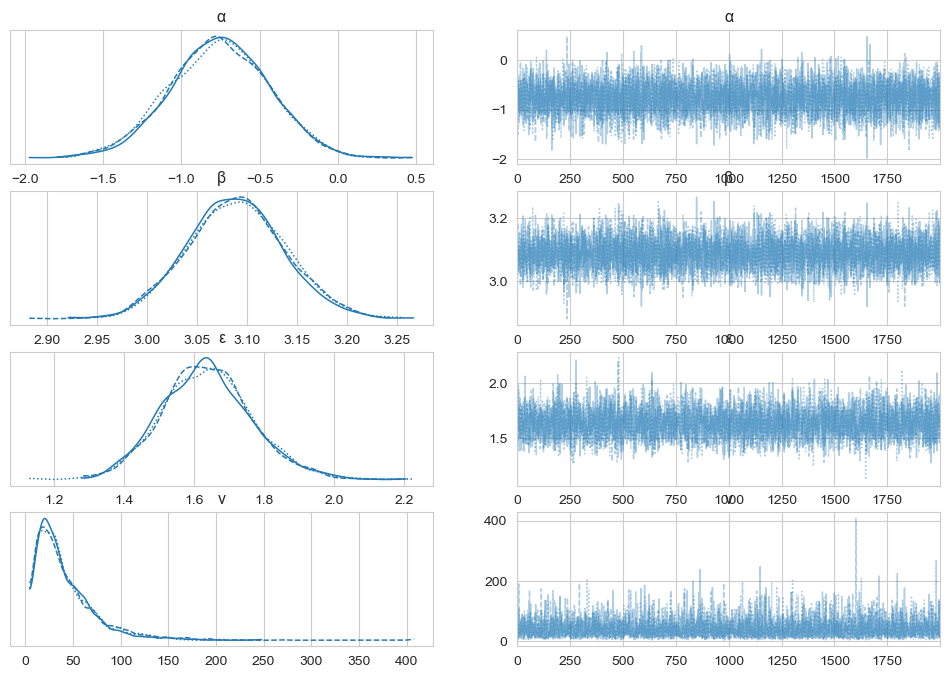

In [13]:
x_centered = X_train - X_train.mean()

with pm.Model() as model_t:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10) # а можно брать mu= y.mean() sd = 1
    β = pm.Normal('β', mu=0, sigma=10)
    ε = pm.HalfNormal('ε', 5)                         # \varepsilon<Tab>
    ν_ = pm.Exponential('ν_', 1/30)
    #ν_ = pm.Gamma('ν_', 2, 0.1)
    #ν_ = pm.Gamma('ν_', mu=20, sd=15)
    ν = pm.Deterministic('ν', ν_+1) # экспоненциальный сдвиг

    y_pred = pm.StudentT('y_pred', mu=α_tmp + β * x_centered,
                         sigma=ε, nu=ν, observed=y_train)

    α = pm.Deterministic('α', α_tmp - β * X_train.mean())

    trace_t = pm.sample(2000, chains=3)

varnames = ['α', 'β', 'ε', 'ν']
az.plot_trace(trace_t, var_names=varnames);

## Иерархическая модель

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


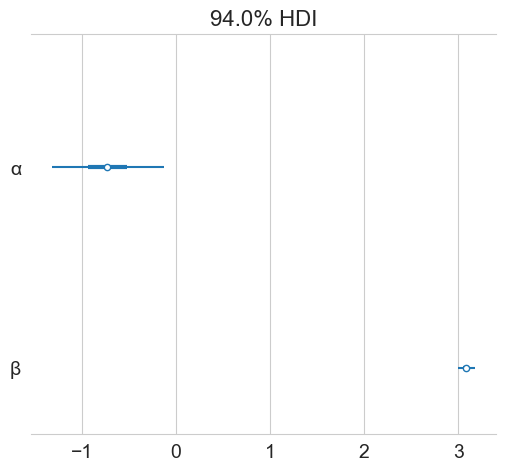

In [14]:
x_centered = X_train - X_train.mean()


with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=10)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp + β * x_centered,
                         sigma=ε, nu=ν, observed=y_train)

    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * X_train.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * X_train.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * X_train.mean())

    # трассировка
    trace_hm = pm.sample(3000,tune = 1000) #target_accept=.8

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);

In [15]:
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, X_train)

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_train)

    trace_p = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


In [16]:
pm.sample_posterior_predictive(trace_hm, model=hierarchical_model, extend_inferencedata=True)
pm.sample_posterior_predictive(trace_t, model=model_t, extend_inferencedata=True)
pm.sample_posterior_predictive(trace_g, model=model_g, extend_inferencedata=True)
y_hm = trace_hm.posterior_predictive['y_pred']
y_t = trace_t.posterior_predictive['y_pred']
y_g = trace_g.posterior_predictive['y_pred']

Sampling: [y_pred]


Sampling: [y_pred]


Sampling: [y_pred]


([], [])

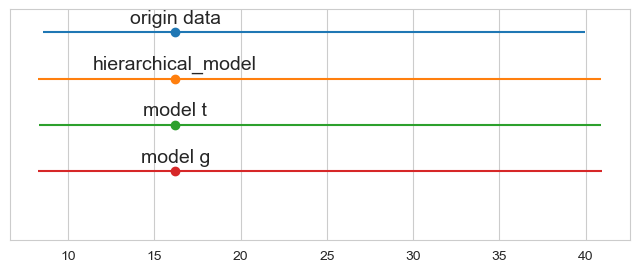

In [17]:
plt.figure(figsize=(8, 3))
data = [y_train, y_hm, y_t, y_g]  # Включите y_int в список данных
labels = ['origin data', 'hierarchical_model', 'model t', 'model g']  # Обновите список меток
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[abs(-err[0])], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-len(data)-0.5, 0.5])  # Используйте len(data) для правильного предела
plt.yticks([])


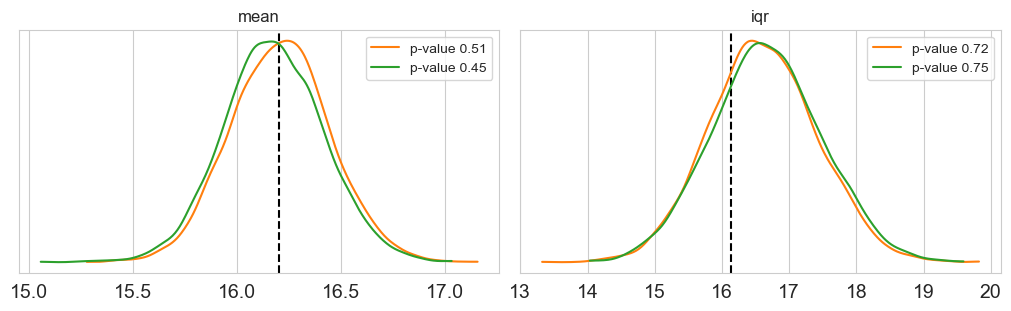

In [18]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

# МАГИЧЕСКАЯ команда распаковки кортежа для его распаковки и передачи вычисления
def iqr(x, axis=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis))

y_g_chain = y_g.stack(samples=('chain', 'draw')).values.T
y_t_chain = y_t.stack(samples=('chain', 'draw')).values.T

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_train)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_g_chain, y_t_chain], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

## Сравнение моделей

In [19]:
pm.compute_log_likelihood(trace_hm, model=hierarchical_model)


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [20]:
pm.compute_log_likelihood(trace_g, model=model_g)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [21]:
pm.compute_log_likelihood(trace_t, model=model_t)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [22]:
diff_loo = az.compare({"hierarchical": trace_hm, "model_g": trace_g, 'model_t':trace_t})
diff_loo

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_g,0,-195.644554,3.383380,0.000000,1.000000e+00,6.991253,0.000000,False,log
model_t,1,-195.804535,3.267543,0.159982,0.000000e+00,6.913744,0.508213,False,log
hierarchical,2,-195.911073,3.368453,0.266519,2.220446e-16,6.943275,0.439980,False,log


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


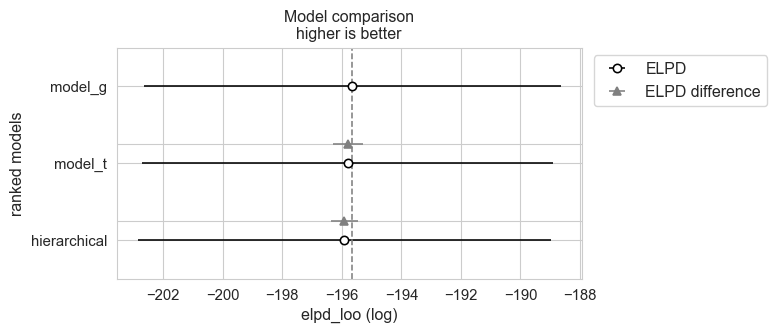

In [23]:
az.plot_compare(diff_loo);

In [24]:
diff_waic = az.compare({"hierarchical": trace_hm, "model_g": trace_g, 'model_t':trace_t}, ic = 'waic')
diff_waic

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureW

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
model_g,0,-195.631194,3.370020,0.000000,1.000000e+00,6.986849,0.000000,True,log
model_t,1,-195.795792,3.258800,0.164599,4.440892e-16,6.911683,0.507378,True,log
hierarchical,2,-195.899134,3.356514,0.267940,0.000000e+00,6.939188,0.441365,True,log


### Финальная модель

In [25]:
train_reg = pd.read_csv('train_reg.csv')
# columns = ['a', 'b', 'c']
X_train = train_reg['x'].values
y_train = train_reg['y'].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.679,0.311,-1.232,-0.077,0.005,0.004,3871.0,4379.0,1.0
β,3.079,0.048,2.986,3.168,0.001,0.001,3784.0,4374.0,1.0
ε,1.690,0.121,1.470,1.922,0.002,0.001,4810.0,4647.0,1.0


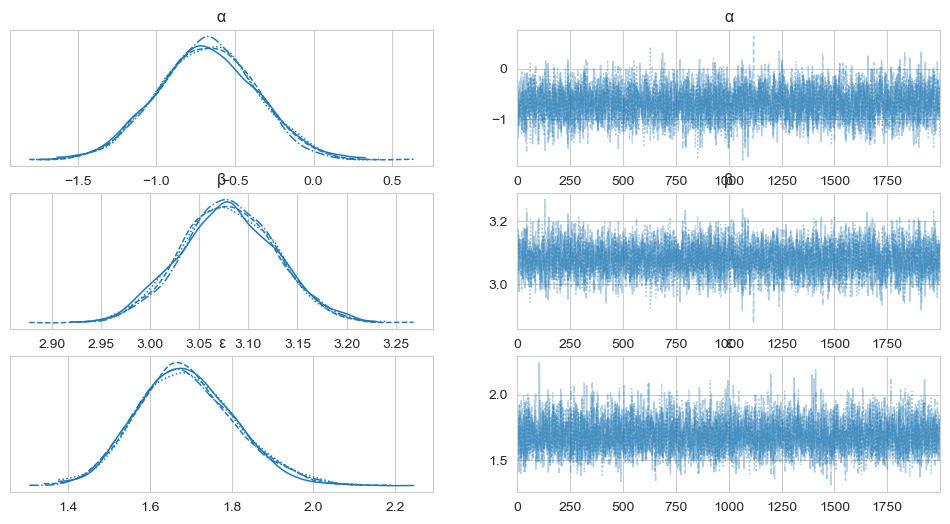

In [26]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 10)
    μ = pm.Deterministic('μ', α + β * X_train)
    y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_train)
    trace_g = pm.sample(2000, tune=2000, chains=4, cores=4)

az.plot_trace(trace_g, var_names=['α', 'β', 'ε']);
az.summary(trace_g).head(3)

In [27]:
alpha = trace_g.posterior['α'].mean(("chain", "draw")).values
betta = trace_g.posterior["β"].mean(("chain", "draw")).values


# Тестовые данные
X_test = pd.read_csv('test_reg.csv')  # Пример тестовых данных

# Предсказания для тестовых данных
y_pred_test = alpha + betta * X_test

In [29]:
from sklearn.metrics import mean_squared_error
y_true = pd.read_csv('test_Y_true_reg.csv')
mean_squared_error(y_true, y_pred_test)

2.370086964540315